In [5]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
from pathlib import Path
from random import randint
import cellpylib as cpl
import matplotlib.pyplot as plt
from tensorflow.keras import layers


In [6]:
IMAGE_SIZE = 128

In [7]:
def run_ca(rule_number, plot=False, save=False):
    cellular_automaton = cpl.init_simple(IMAGE_SIZE)  
    cellular_automaton = cpl.evolve(cellular_automaton, timesteps=IMAGE_SIZE, memoize=True,
                                    apply_rule=lambda n, c, t: cpl.nks_rule(n, rule_number))
    if plot:
        cpl.plot(cellular_automaton)
    if save:
        path = './nks/' + str(rule_number) 
        Path(path).mkdir(parents=True, exist_ok=True)
        plt.imsave(path + '/out.png', cellular_automaton, cmap='binary')

In [8]:
for i in range(0, 256):
    run_ca(i, save=True)

In [9]:
dataset = keras.preprocessing.image_dataset_from_directory("./nks", image_size=(IMAGE_SIZE, IMAGE_SIZE), batch_size=32, color_mode='grayscale', seed=123)
# print first few entries
for image_batch, labels_batch in dataset.take(1):
    print(image_batch.shape)
    print(labels_batch.numpy())

Found 256 files belonging to 256 classes.
(32, 128, 128, 1)
[103 128  20  53  51  28   1 161   2  70  37 251 250 156  80 216 239 201
 177  87 253 149 255 133 221   0  91  65  81  82 214 236]


In [10]:
dataset = dataset.prefetch(buffer_size=32)

In [11]:
# create model
model = keras.Sequential([
    # CenterCrop(48, 48),
    # Rescaling(1./255),
    layers.Conv2D(32, 3, activation='relu'),
    layers.MaxPooling2D(),
    layers.Conv2D(32, 3, activation='relu'),
    layers.BatchNormalization(),
    layers.Conv2D(32, 3, activation='relu'),
    layers.MaxPooling2D(),
    layers.Conv2D(32, 3, activation='relu'),
    layers.Flatten(),
    # classification layer
    layers.Dense(256, activation='softmax')
])

# compile model
model.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

# train model
model.fit(dataset, epochs=300)

Epoch 1/300
8/8 [==============================] - 5s 12ms/step - loss: 9.3763 - accuracy: 0.0000e+00
Epoch 2/300
8/8 [==============================] - 0s 11ms/step - loss: 5.3099 - accuracy: 0.0469
Epoch 3/300
8/8 [==============================] - 0s 10ms/step - loss: 4.8979 - accuracy: 0.0820
Epoch 4/300
8/8 [==============================] - 0s 11ms/step - loss: 4.2840 - accuracy: 0.1211
Epoch 5/300
8/8 [==============================] - 0s 11ms/step - loss: 3.9584 - accuracy: 0.1875
Epoch 6/300
8/8 [==============================] - 0s 11ms/step - loss: 3.6413 - accuracy: 0.2461
Epoch 7/300
8/8 [==============================] - 0s 11ms/step - loss: 3.3420 - accuracy: 0.3125
Epoch 8/300
8/8 [==============================] - 0s 11ms/step - loss: 3.0429 - accuracy: 0.3125
Epoch 9/300
8/8 [==============================] - 0s 11ms/step - loss: 2.8649 - accuracy: 0.3242
Epoch 10/300
8/8 [==============================] - 0s 11ms/step - loss: 2.5589 - accuracy: 0.3594
Epoch 11/300
8/

In [12]:
# save model
model.save('nks.h5')

In [13]:
# load model
model = keras.models.load_model('nks.h5')

# test model
test_dataset = keras.preprocessing.image_dataset_from_directory("./nks", image_size=(IMAGE_SIZE, IMAGE_SIZE), batch_size=32, color_mode='grayscale',seed=123)
model.evaluate(test_dataset)

Found 256 files belonging to 256 classes.
8/8 [==============================] - 0s 4ms/step - loss: 1.2845 - accuracy: 0.5430


[1.2844738960266113, 0.54296875]

In [14]:
# predict
predictions = model.predict(test_dataset)
print(np.argmax(predictions, axis=1))
# print true labels
for image_batch, labels_batch in test_dataset.take(1):
    print(labels_batch.numpy())
    

8/8 [==============================] - 0s 3ms/step
[ 30  51  17  55 143 176  51 219 219 219 167 130 215 154 219  85 155 219
  20  64  87 188  93  51  74 189 198  50  51  45  47  78  90 114  55  90
  47 107 159  97 114  47 114 219  76  89 205  97  15 219 147  47 138  14
 170 179 219  97 233 110 114 114 114 181 188  99 181 134 161 136  45  51
  58 130  19  43 164 222  90  47 135  47  97  63  64  65 232  29 114 187
  17 163 181  20 241 219  51  51 255 225  51  47 117 130  97 247  47 141
 109  51 181  52 130  47  34 181 206 102 173  51  61 201 203 245 181 150
 145 250 114   1 181  55 240  97 130 121 110 180 126  97 130 218  47  17
 100   6  12  57  51 130 156  48 188 213 219  92 114 178 114  47 114 137
 181 155  28 219  26  90  47  34  49 132  79  83 219  90  54  49  47 198
  55 214 219 229 249 159  41  51 181 168  51  47  97 148  98  66   8 253
 111 196 188 119 198 238 231 244  37  90 227  47  90 136 172  49  31  56
 114 128 114 219 152 129 192  35 209  20  96  49 211  51 181 105  72  79


[254 176 122 211  98 195 194 111  23 209  62  18 210  96 130  80 115  48
 135 235  66 106  84 128  22  44 165  71 139 246 117 214]


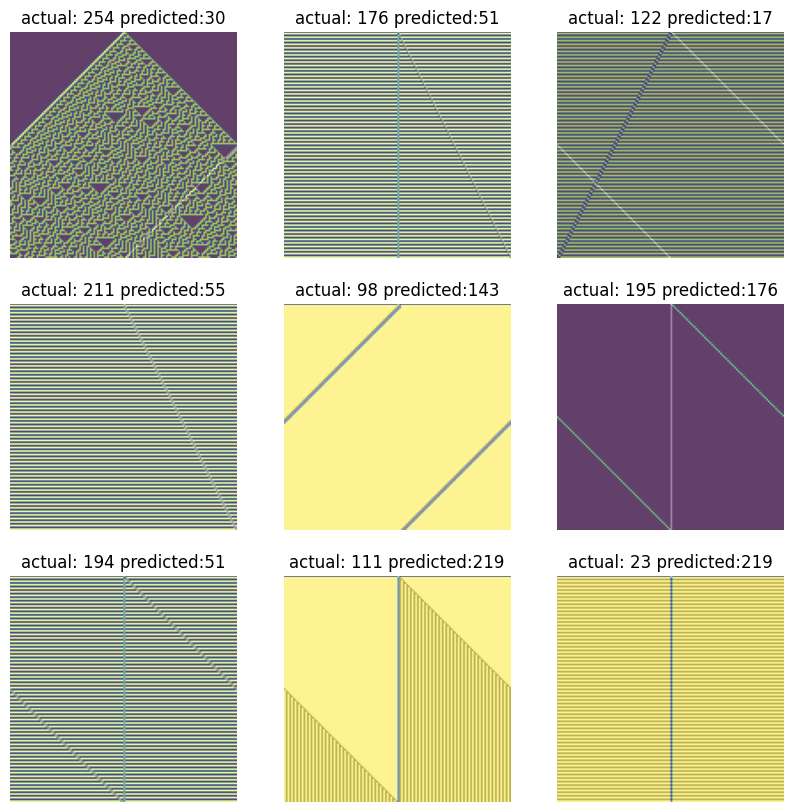

In [23]:
# plot the labels in the validation set, and the predictions
for image_batch, labels_batch in test_dataset.take(1):
    print(labels_batch.numpy())
    # plot the first 9 images
    plt.figure(figsize=(10, 10))
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(image_batch[i].numpy().astype("uint8"), cmap='binary', alpha=0.5)
        plt.title("actual: " + str(labels_batch[i].numpy().astype("uint8")) + " predicted:" + str(np.argmax(predictions[i])))
        # overlay the predicted celluar automaton
        plt.imshow(cpl.evolve(cpl.init_simple(IMAGE_SIZE), timesteps=IMAGE_SIZE, memoize=True,
                                    apply_rule=lambda n, c, t: cpl.nks_rule(n, np.argmax(predictions[i]))), alpha=0.5,)
        plt.axis("off")
